In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from keras.datasets import cifar10

from keras.utils import to_categorical
from keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from keras.models import Sequential
from keras.layers import MaxPooling2D
from keras.optimizers.legacy import Adam

from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. Ratios in both train and test set are equal for all classes.

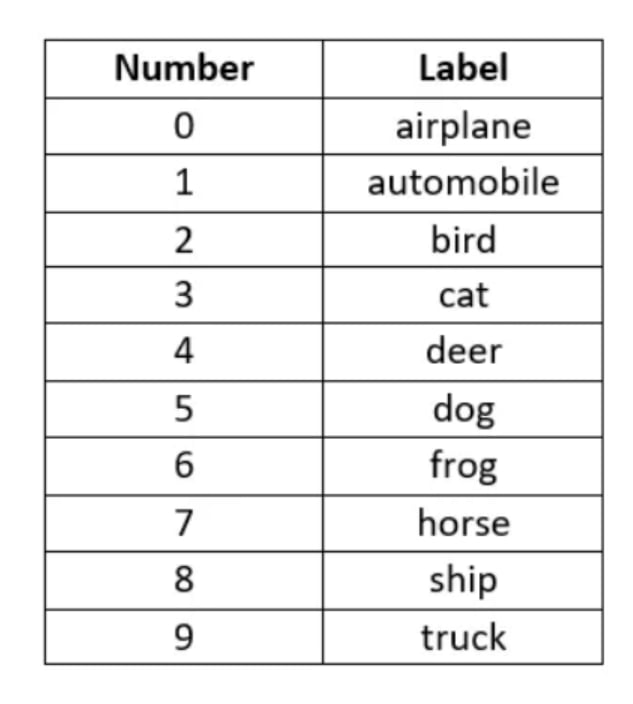

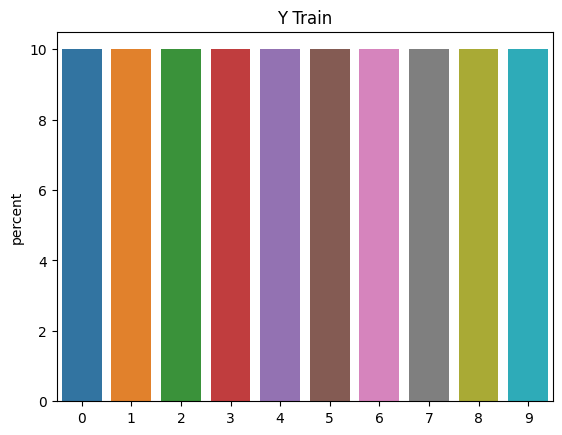

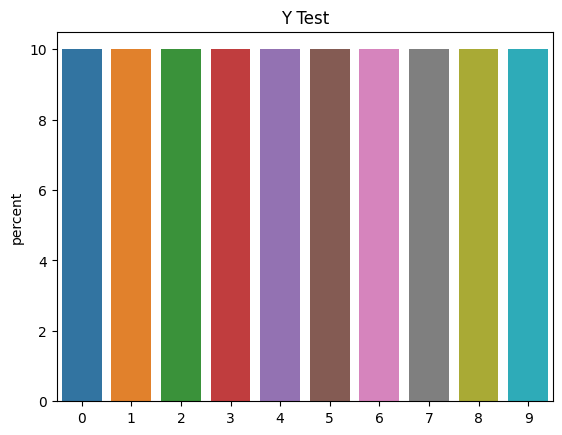

In [61]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
sns.countplot(pd.DataFrame(to_categorical(Y_train)), stat="percent")
plt.title("Y Train")
plt.show()
sns.countplot(pd.DataFrame(to_categorical(Y_test)), stat="percent")
plt.title("Y Test")
plt.show()

# MODELS

In [26]:
def LeNet(kernel, pool):
    model = Sequential()
    model.add(Conv2D(32, kernel, input_shape=(32,32,3), activation="sigmoid"))
    model.add(MaxPooling2D(pool_size=pool))
    model.add(Conv2D(32, kernel, padding="same", activation="sigmoid"))
    model.add(MaxPooling2D(pool_size=pool))
    model.add(Flatten())
    model.add(Dense(120, activation="sigmoid"))
    model.add(Dense(84, activation="sigmoid"))
    model.add(Dense(10, activation="softmax"))

    return model


def AlexNet(kernel, pool):
    model = Sequential()
    model.add(Conv2D(32, kernel, input_shape=(32,32,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=pool))
    model.add(Conv2D(32, kernel, padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=pool))

    model.add(Conv2D(32, kernel, padding="same", activation="relu"))
    model.add(Conv2D(32, kernel, padding="same", activation="relu"))
    model.add(Conv2D(32, kernel, padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=pool))

    model.add(Flatten())
    model.add(Dense(4096, activation="relu"))
    model.add(Dense(4096, activation="relu"))
    model.add(Dense(10, activation="softmax"))

    return model


def VGG16(kernel, pool):
    model = Sequential()
    model.add(Conv2D(64, kernel, input_shape=(32,32,3), activation="relu"))
    model.add(Conv2D(64, kernel, padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=pool))

    model.add(Conv2D(128, kernel, padding="same", activation="relu"))
    model.add(Conv2D(128, kernel, padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=pool))

    model.add(Conv2D(256, kernel, padding="same", activation="relu"))
    model.add(Conv2D(256, kernel, padding="same", activation="relu"))
    model.add(Conv2D(256, kernel, padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=pool))

    model.add(Conv2D(512, kernel, padding="same", activation="relu"))
    model.add(Conv2D(512, kernel, padding="same", activation="relu"))
    model.add(Conv2D(512, kernel, padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=pool))

    model.add(Conv2D(512, kernel, padding="same", activation="relu"))
    model.add(Conv2D(512, kernel, padding="same", activation="relu"))
    model.add(Conv2D(512, kernel, padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=pool))

    model.add(Flatten())
    model.add(Dense(4096, activation="relu"))
    model.add(Dense(4096, activation="relu"))
    model.add(Dense(10, activation="softmax"))

    return model

In [36]:
def do_augmentation(X_train, Y_train):

    datagen = ImageDataGenerator(rotation_range=15, horizontal_flip=True, vertical_flip=True)
    datagen.fit(X_train)

    num_augmented_images = len(X_train)  # Number of augmented images you want to generate
    augmented_images = []
    augmented_labels = []

    # Generate augmented images in batches
    for x_batch, y_batch in datagen.flow(X_train, Y_train, batch_size=32):
        augmented_images.extend(x_batch)
        augmented_labels.extend(y_batch)
        if len(augmented_images) >= num_augmented_images:
            break

    # Convert lists to numpy arrays
    augmented_images = np.array(augmented_images[:num_augmented_images])
    augmented_labels = np.array(augmented_labels[:num_augmented_images])

    # Concatenate the original and augmented data
    X_train_augmented = np.concatenate((X_train, augmented_images))
    Y_train_augmented = np.concatenate((Y_train, augmented_labels))

    return X_train_augmented, Y_train_augmented

* normalization: image pixels are in a range from 0–255 <br>
* Y to categorical makes: [3] -> [0,0,1,0,0,0,0,0,0,0]

In [37]:
def my_load_data(augmentation=False):
    (X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

    X_train = X_train/255.0
    X_test = X_test/255.0


    # image augmentation
    if augmentation:
        X_train, Y_train = do_augmentation(X_train, Y_train)        
        

    # one hot encoding to 10 classes
    Y_train = to_categorical(Y_train,10)
    Y_test = to_categorical(Y_test,10)

    print("SHAPES: ", X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

    return X_train, Y_train, X_test, Y_test

def my_plot_accuracy(train_accuracy1, val_accuracy1, train_accuracy2, val_accuracy2):
    epochs = range(1, max(len(train_accuracy1),len(train_accuracy2)) + 1)
    plt.ylim(0,1)
    plt.plot(epochs, train_accuracy1, label='Model 1 training')
    plt.plot(epochs, val_accuracy1, label='Model 1 validation')
    plt.plot(epochs, train_accuracy2, label='Model 2 training')
    plt.plot(epochs, val_accuracy2, label='Model 2 validation')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [38]:
def main(model, lr=0.001, batch=100, augmentation=False):

    X_train, Y_train, X_test, Y_test = my_load_data(augmentation)

    model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=lr), metrics=["accuracy"])
    model.summary()

    # Fit
    model_fit = model.fit(X_train, Y_train, epochs=20, verbose=1, batch_size=batch, validation_data=(X_test,Y_test))

    # Get accuracy
    train_accuracy = model_fit.history['accuracy']
    val_accuracy = model_fit.history['val_accuracy']

    # Predict
    # we get probabilities for each class
    Y_predictions = model.predict(X_test)

    # Class Affiliation
    # which index has the highest probability 
    Y_predictions = np.argmax(Y_predictions, axis=1)
    Y_test = np.argmax(Y_test, axis=1)



    # Classification report
    print(classification_report(Y_test, Y_predictions))

    # Confusion matrix
    labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
    cm = ConfusionMatrixDisplay(confusion_matrix(Y_test, Y_predictions), display_labels=labels)
    cm.plot(xticks_rotation=50, cmap=plt.cm.Blues)

    # Failed pictures
    A,B = 5,5
    fig, axes = plt.subplots(A, B, figsize=(12,15))
    axes = axes.ravel()
    misclassified_idx = np.where(Y_predictions != Y_test)[0]
    for i in np.arange(0, A*B):
        axes[i].imshow(X_test[misclassified_idx[i]])
        axes[i].set_title(f"True: {labels[Y_test[misclassified_idx[i]]]} \nPredicted: {labels[Y_predictions[misclassified_idx[i]]]}")
        axes[i].axis('off')
    plt.show()


    return train_accuracy, val_accuracy

SHAPES:  (50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 15, 15, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 7, 7, 32)          9248      
                                                 

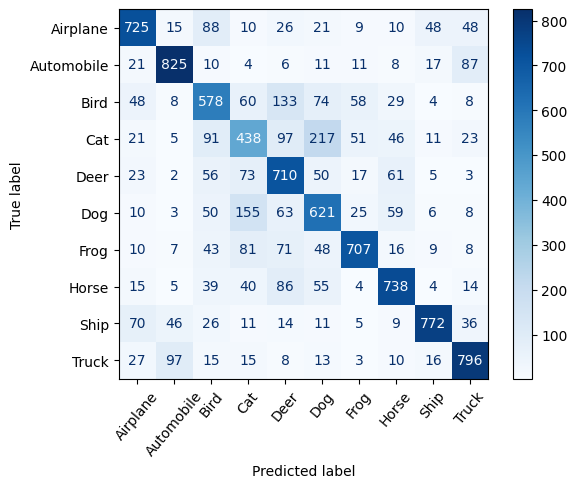

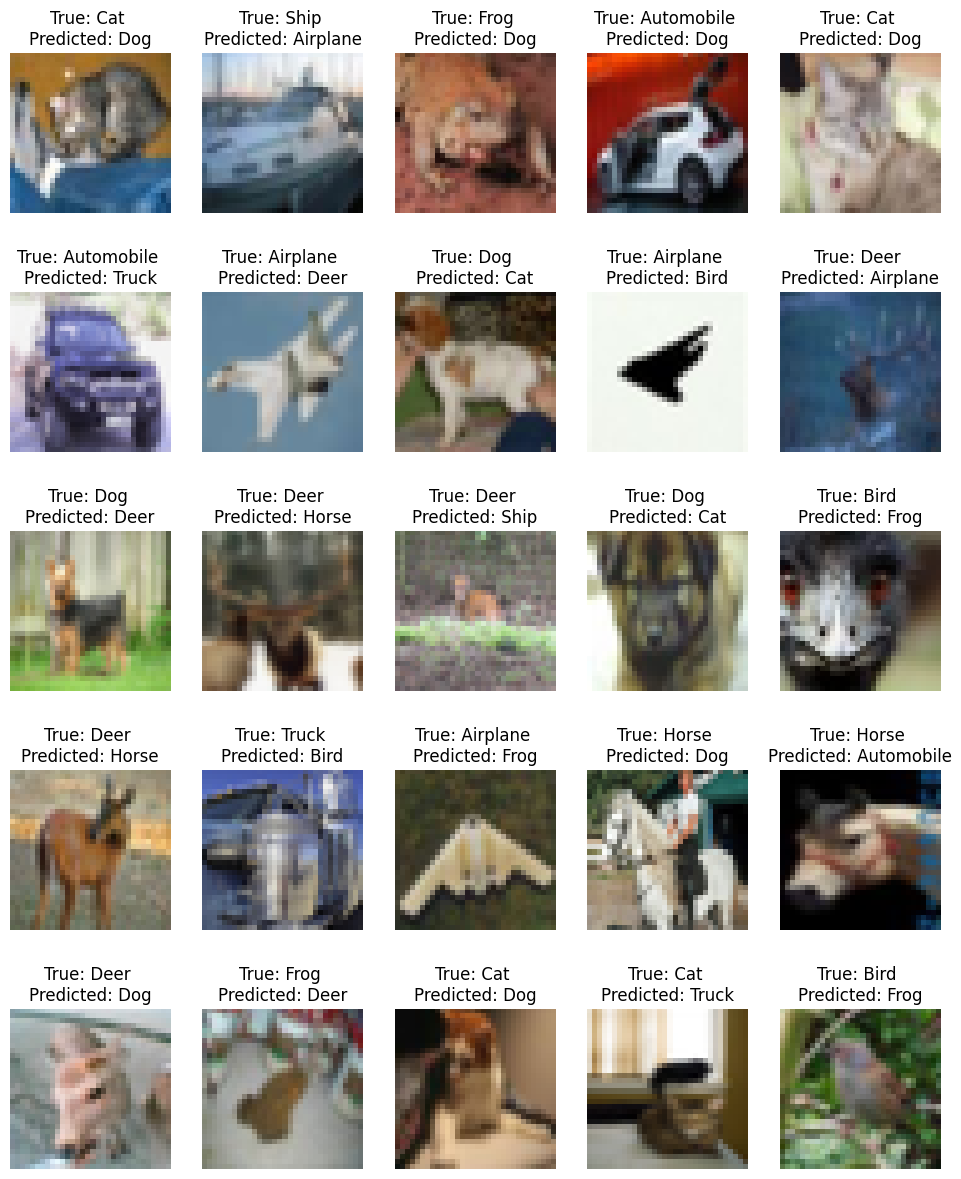

SHAPES:  (50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 15, 15, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 1568)              0         
                                                 

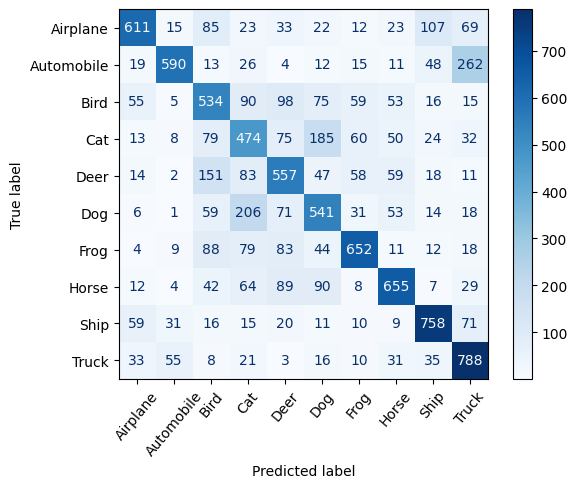

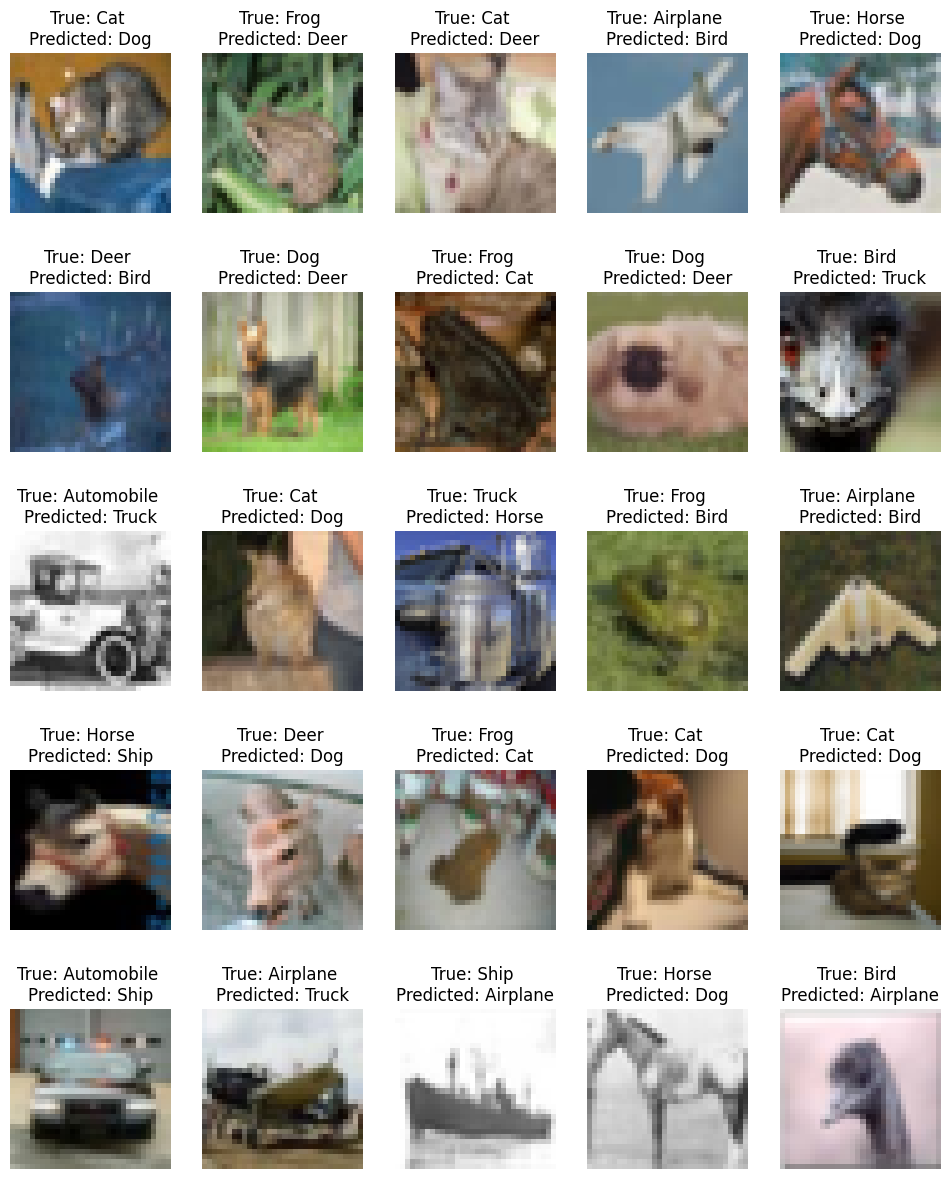

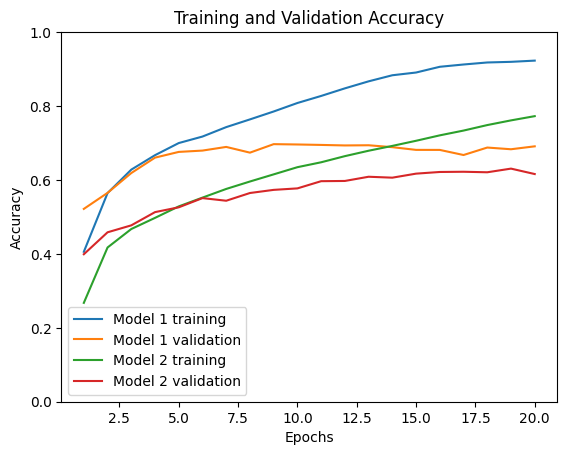

In [19]:
train_accuracy_1, val_accuracy_1 = main(AlexNet((3,3), (2,2)))
train_accuracy_2, val_accuracy_2 = main(LeNet((3,3), (2,2)))

my_plot_accuracy(train_accuracy_1, val_accuracy_1, train_accuracy_2, val_accuracy_2)

## VGG16 nie działa, za dużo pooling

SHAPES:  (50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 15, 15, 32)        9248      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_24 (Conv2D)          (None, 7, 7, 32)          9248      
                                                 

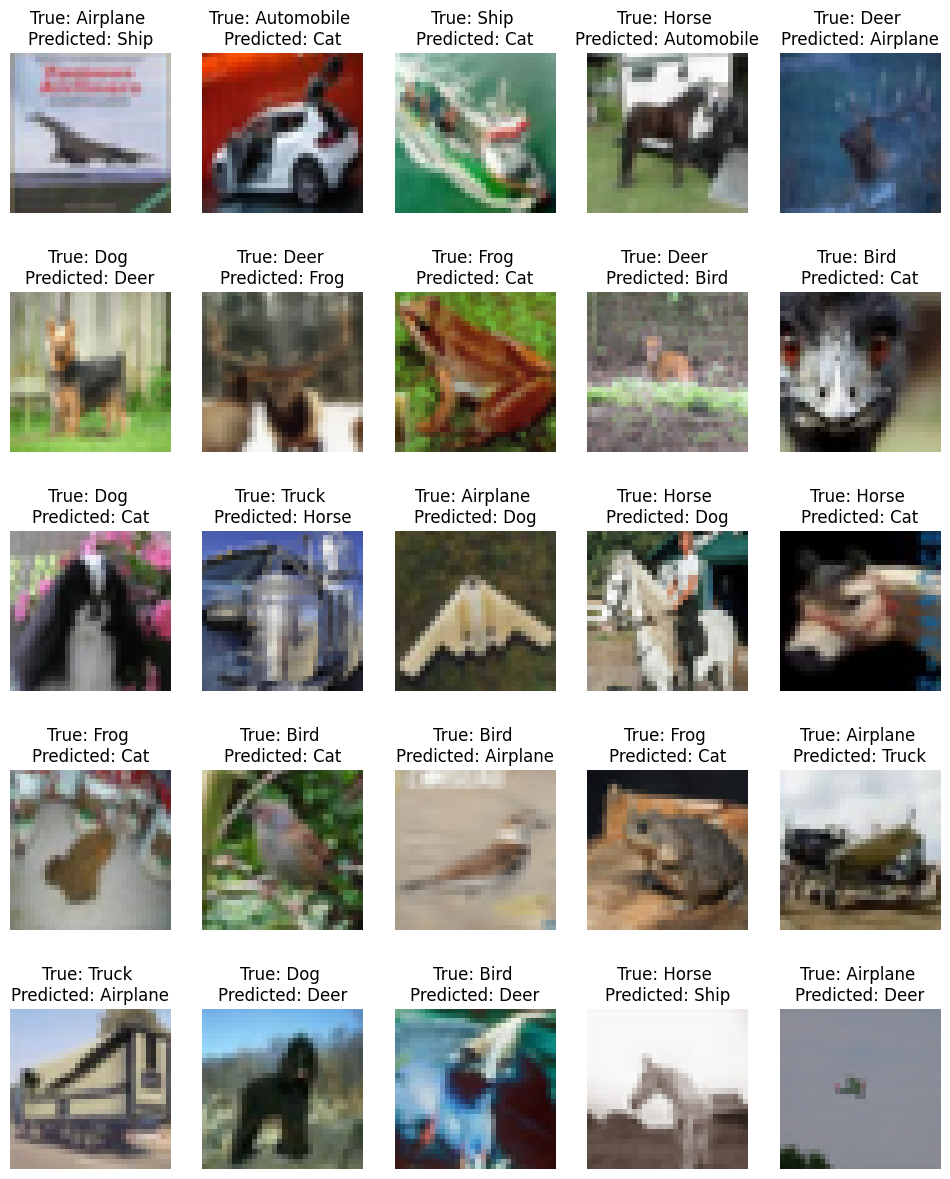

ValueError: Exception encountered when calling layer "max_pooling2d_20" (type MaxPooling2D).

Negative dimension size caused by subtracting 2 from 1 for '{{node max_pooling2d_20/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1]](Placeholder)' with input shapes: [?,1,1,512].

Call arguments received by layer "max_pooling2d_20" (type MaxPooling2D):
  • inputs=tf.Tensor(shape=(None, 1, 1, 512), dtype=float32)

In [25]:
train_accuracy_1, val_accuracy_1 = main(AlexNet((3,3), (2,2)))
train_accuracy_2, val_accuracy_2 = main(VGG16((3,3), (2,2)))

my_plot_accuracy(train_accuracy_1, val_accuracy_1, train_accuracy_2, val_accuracy_2)

SHAPES:  (50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 15, 15, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 32)          9248      
                                                 

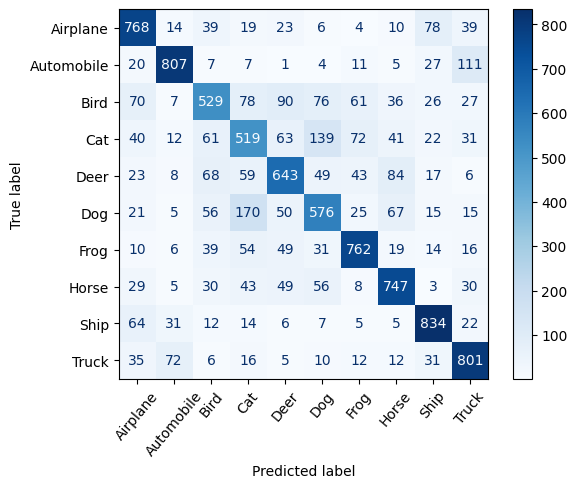

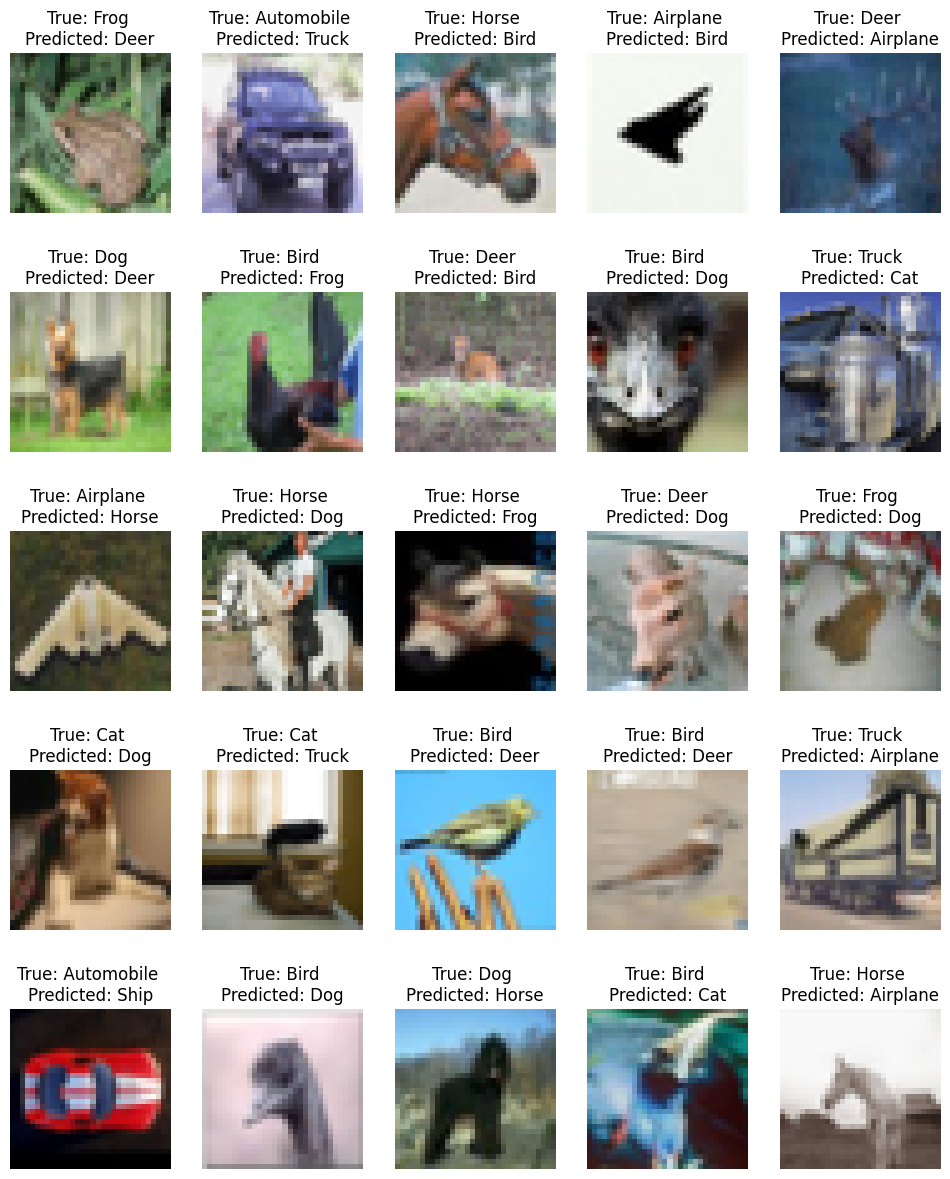

SHAPES:  (50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 29, 29, 32)        1568      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 32)        16416     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 7, 7, 32)          16416     
                                                 

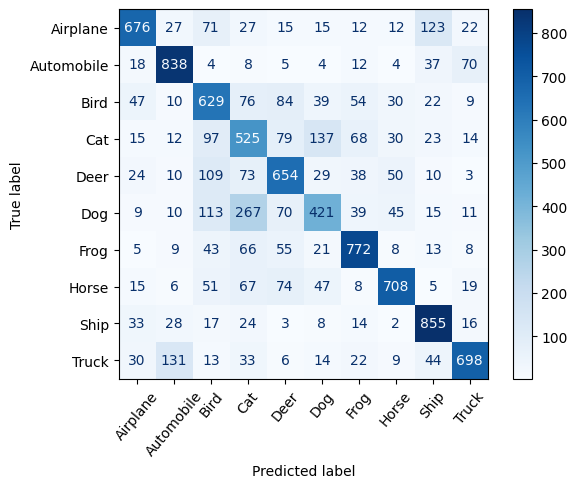

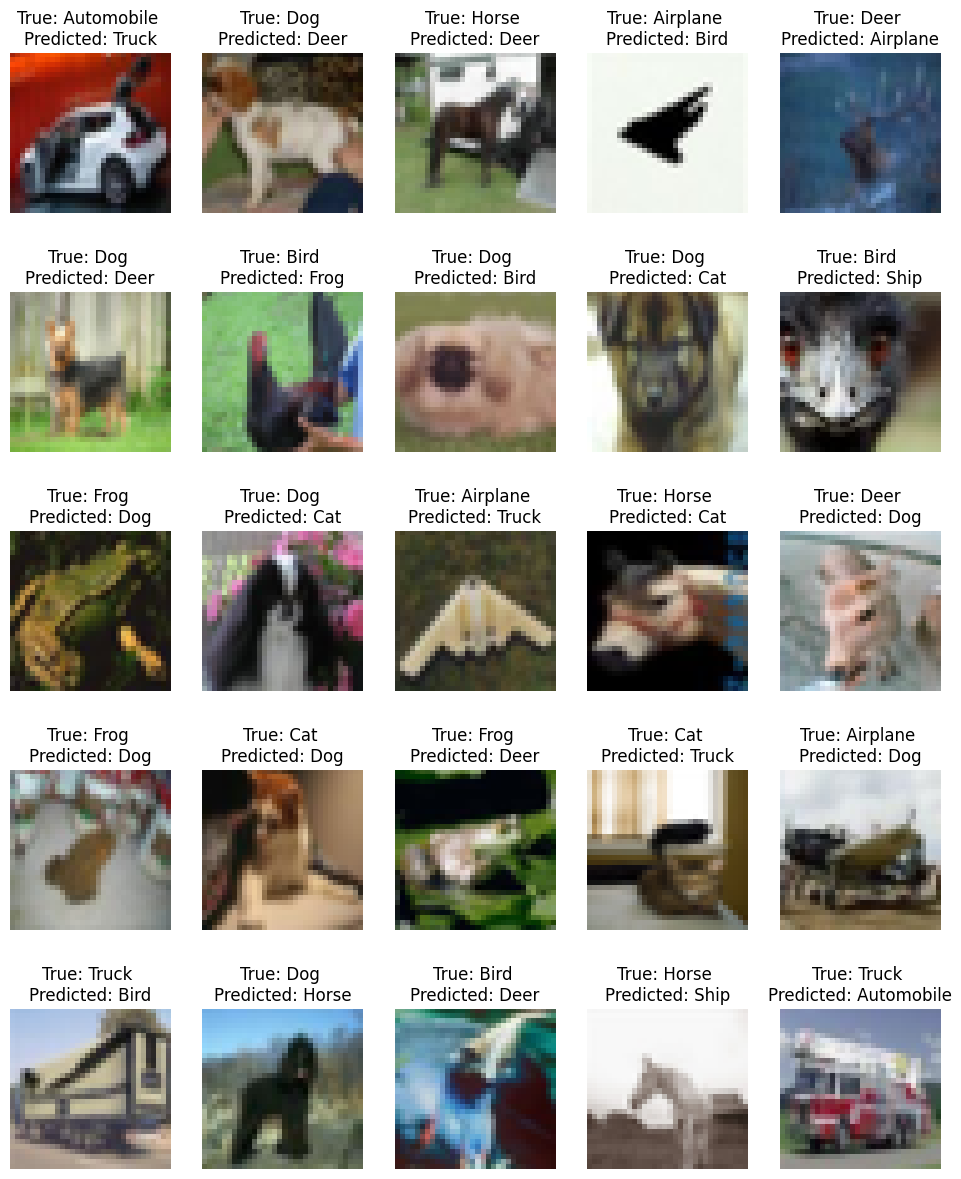

In [7]:
train_accuracy_1, val_accuracy_1 = main(AlexNet((3,3), (2,2)))
train_accuracy_2, val_accuracy_2 = main(AlexNet((4,4), (2,2)))

my_plot_accuracy(train_accuracy_1, val_accuracy_1, train_accuracy_2, val_accuracy_2)

SHAPES:  (50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 15, 15, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 7, 7, 32)          9248      
                                                 

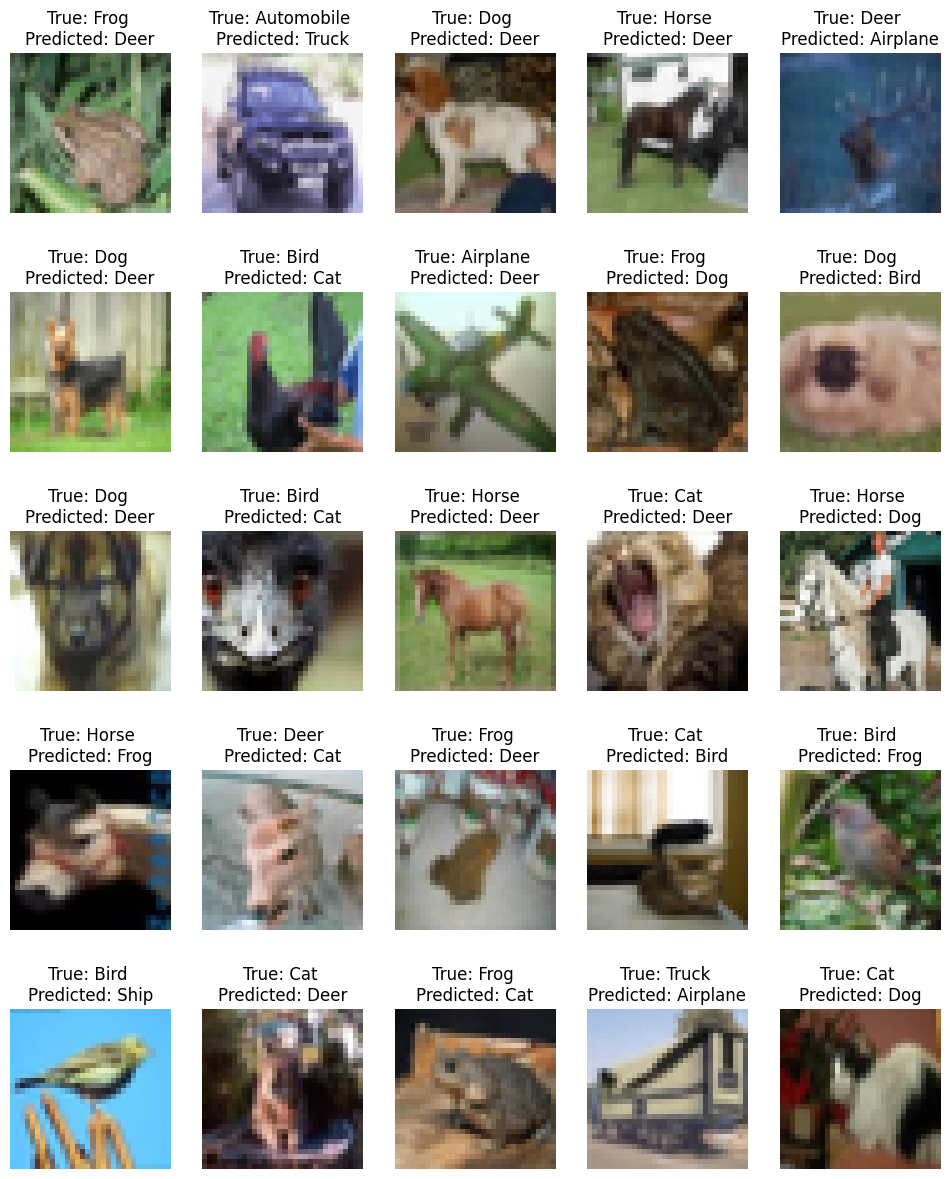

SHAPES:  (50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 10, 10, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 10, 10, 32)        9248      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 3, 3, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 3, 3, 32)          9248      
                                                 

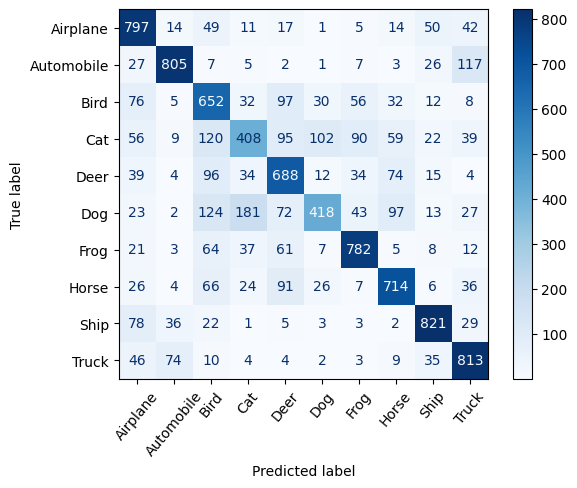

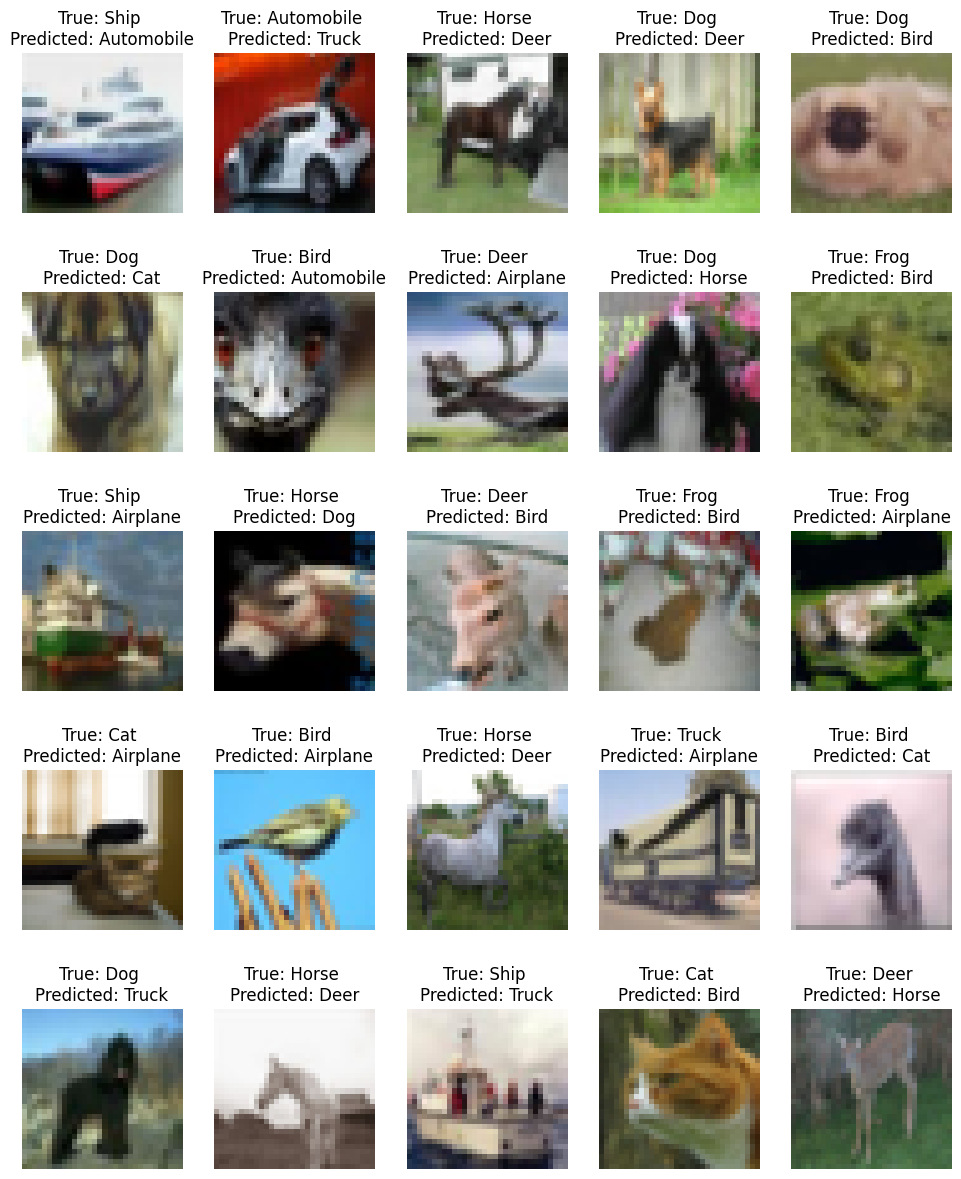

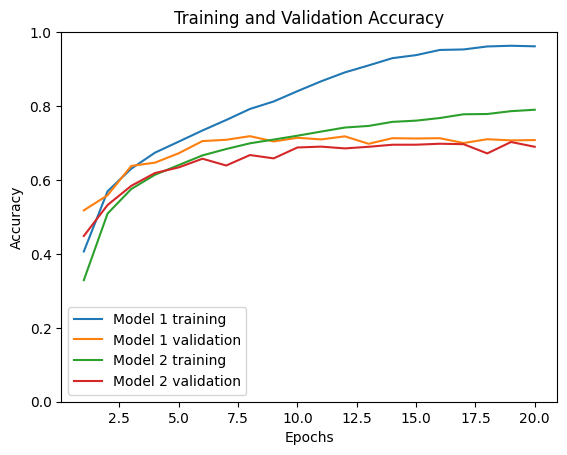

In [8]:
train_accuracy_1, val_accuracy_1 = main(AlexNet((3,3), (2,2)))
train_accuracy_2, val_accuracy_2 = main(AlexNet((3,3), (3,3)))

my_plot_accuracy(train_accuracy_1, val_accuracy_1, train_accuracy_2, val_accuracy_2)

SHAPES:  (50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 15, 15, 32)        9248      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 7, 7, 32)          9248      
                                                 

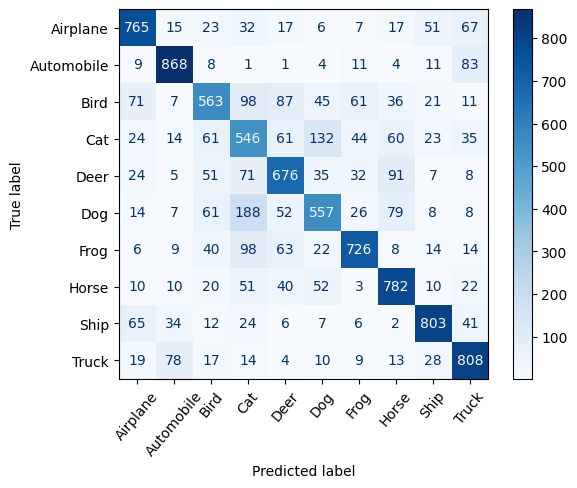

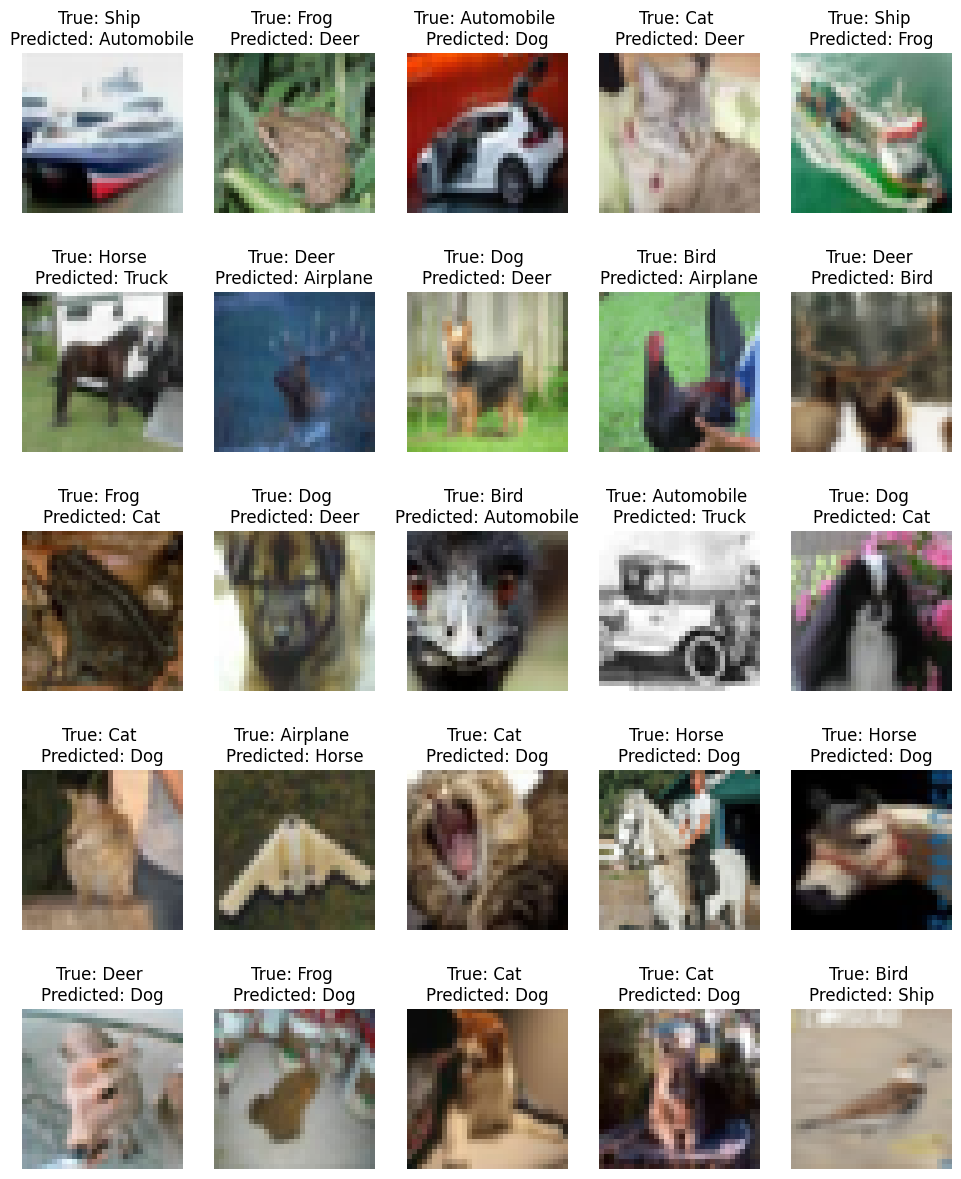

SHAPES:  (50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 15, 15, 32)        9248      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (None, 7, 7, 32)          9248      
                                                 

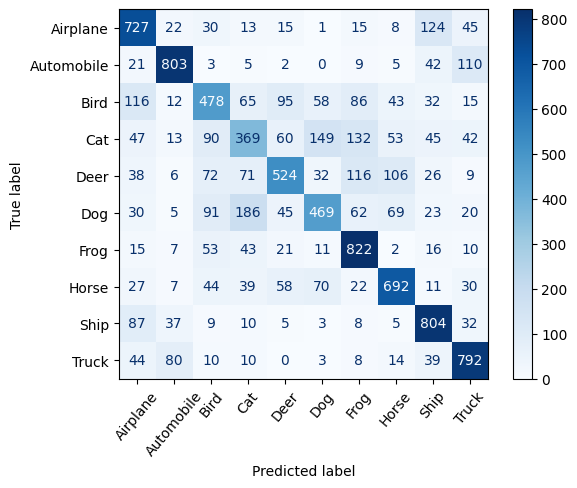

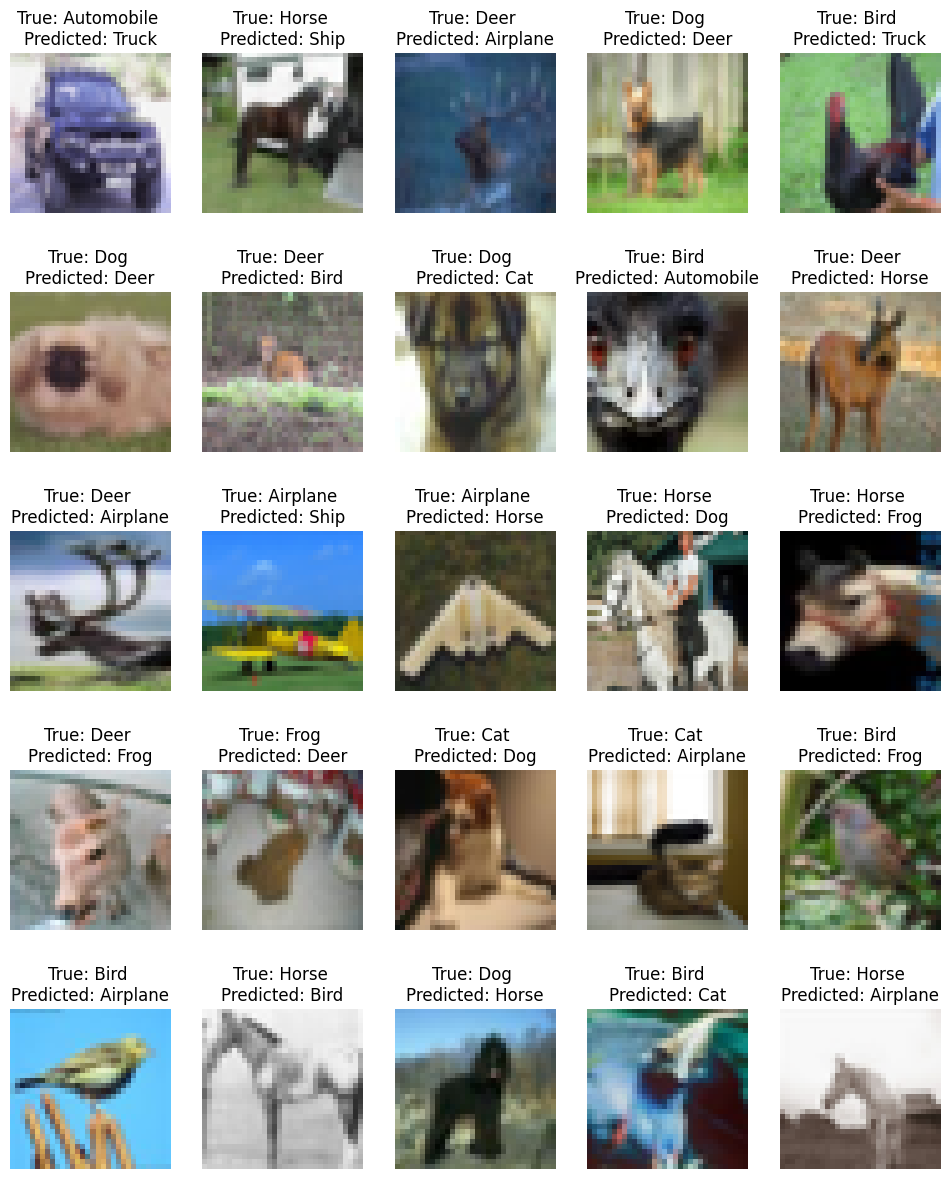

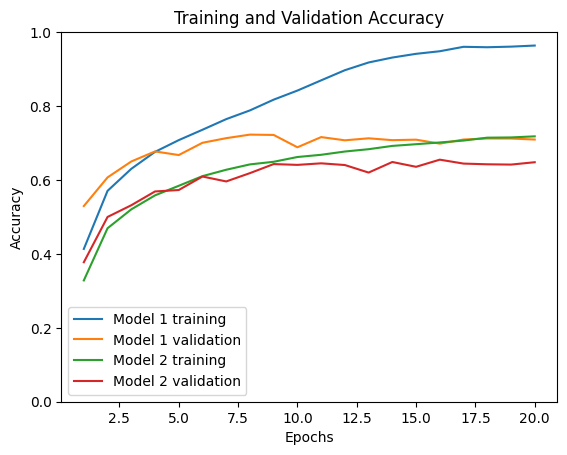

In [10]:
train_accuracy_1, val_accuracy_1 = main(AlexNet((3,3), (2,2)))
train_accuracy_2, val_accuracy_2 = main(AlexNet((3,3), (2,2)), lr=0.003)

my_plot_accuracy(train_accuracy_1, val_accuracy_1, train_accuracy_2, val_accuracy_2)



SHAPES:  (50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          9248      
                                                 

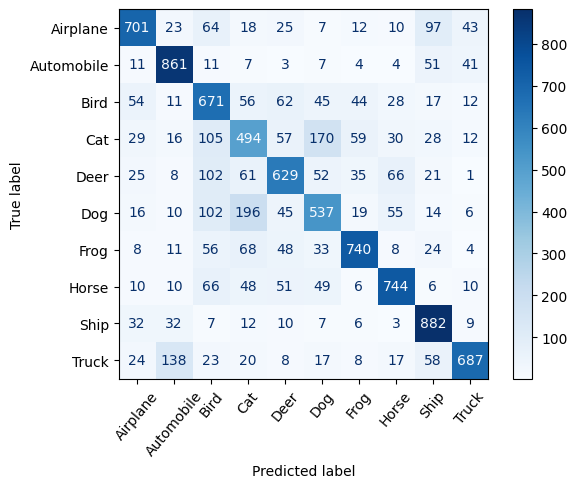

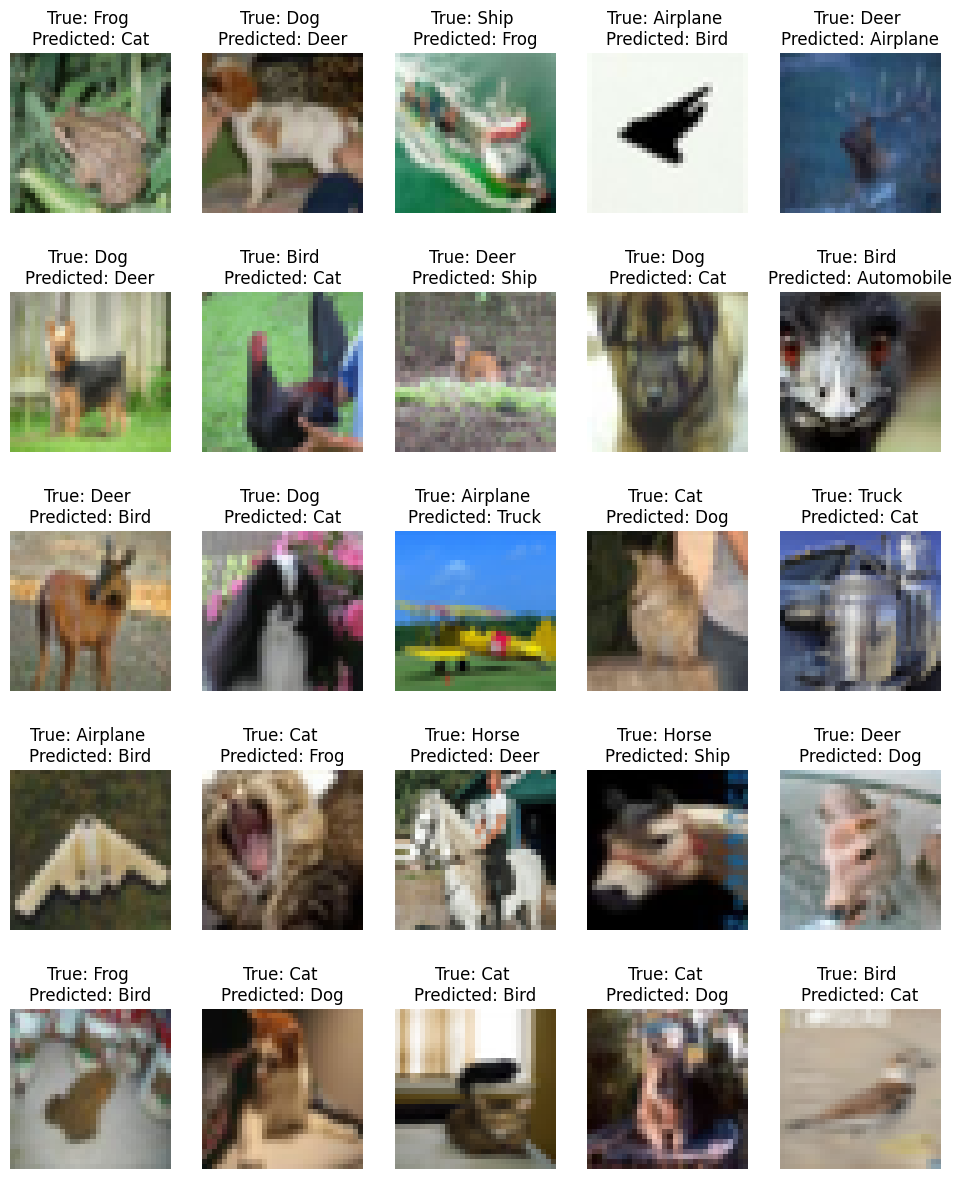

SHAPES:  (50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 15, 15, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 32)          9248      
                                                 

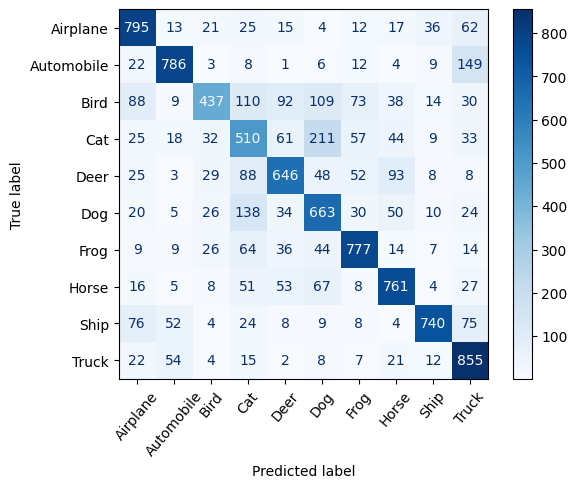

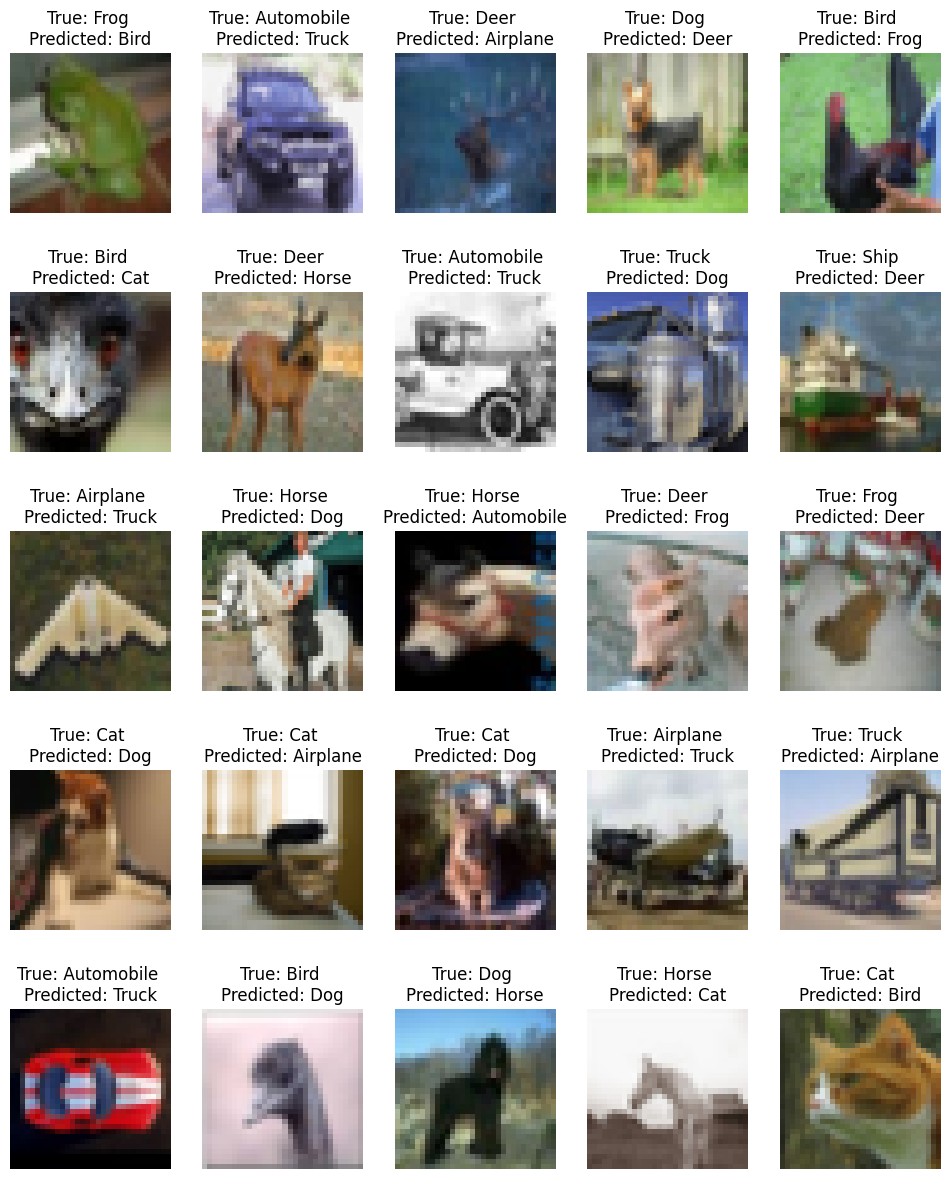

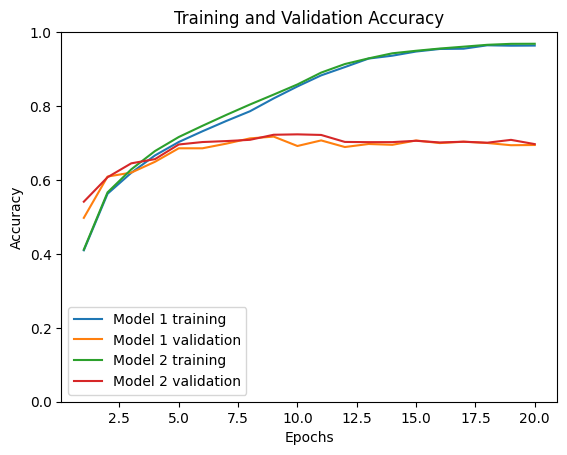

In [5]:
train_accuracy_1, val_accuracy_1 = main(AlexNet((3,3), (2,2)))
train_accuracy_2, val_accuracy_2 = main(AlexNet((3,3), (2,2)), lr=0.0008)

my_plot_accuracy(train_accuracy_1, val_accuracy_1, train_accuracy_2, val_accuracy_2)

SHAPES:  (50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_36 (Conv2D)          (None, 15, 15, 32)        9248      
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 7, 7, 32)          9248      
                                                 

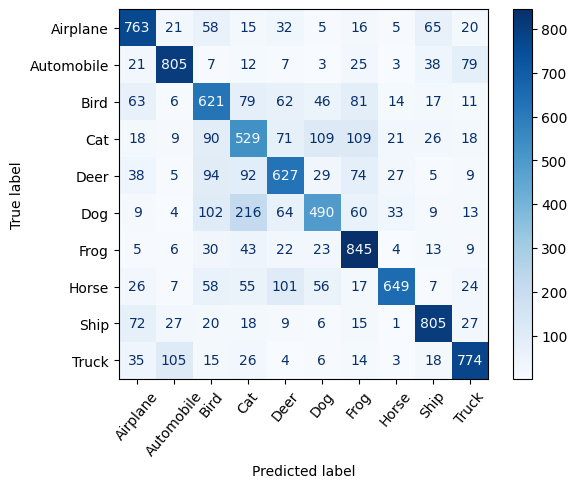

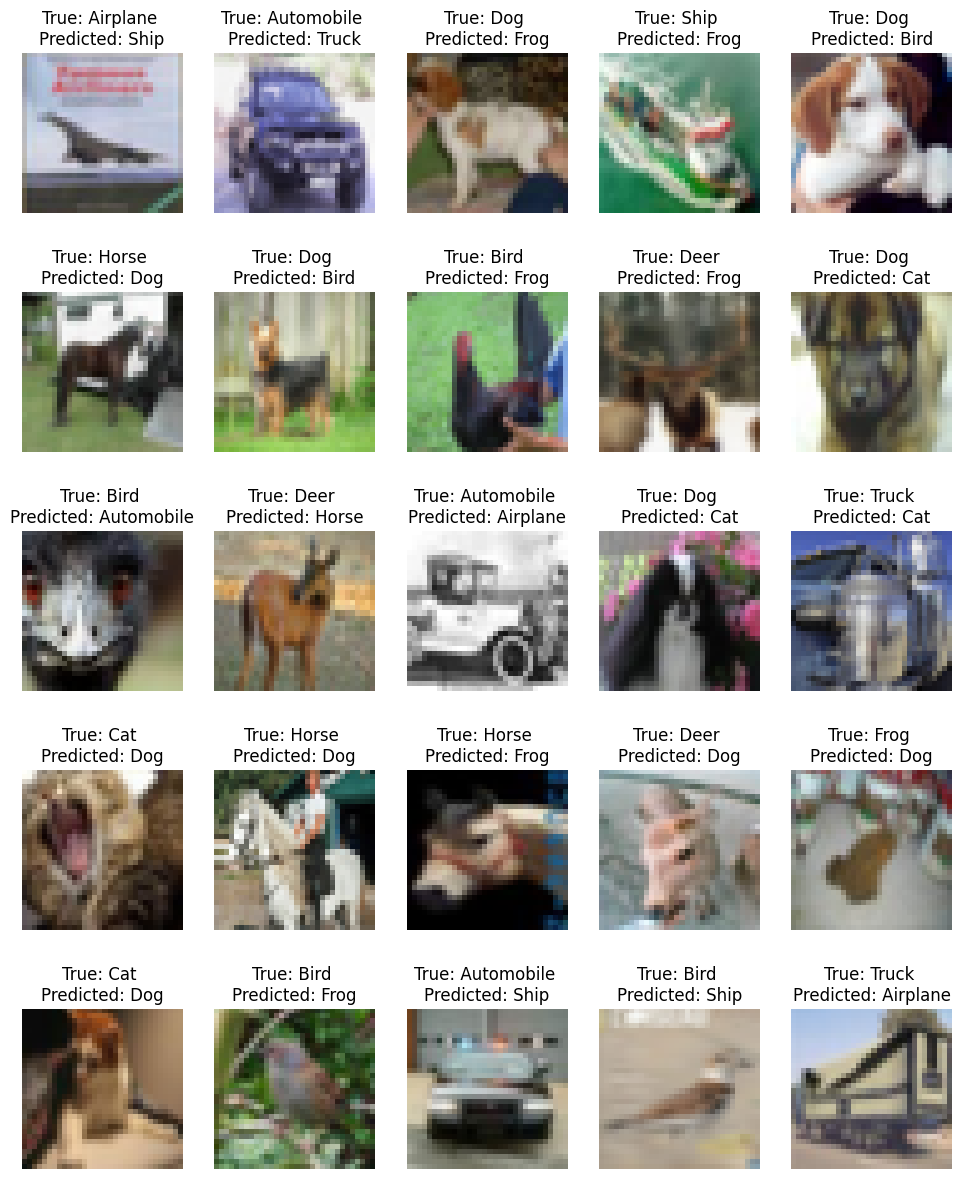

SHAPES:  (50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_41 (Conv2D)          (None, 15, 15, 32)        9248      
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_42 (Conv2D)          (None, 7, 7, 32)          9248      
                                                 

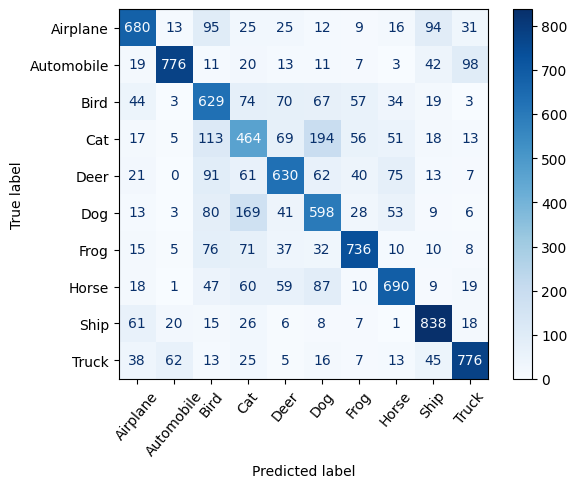

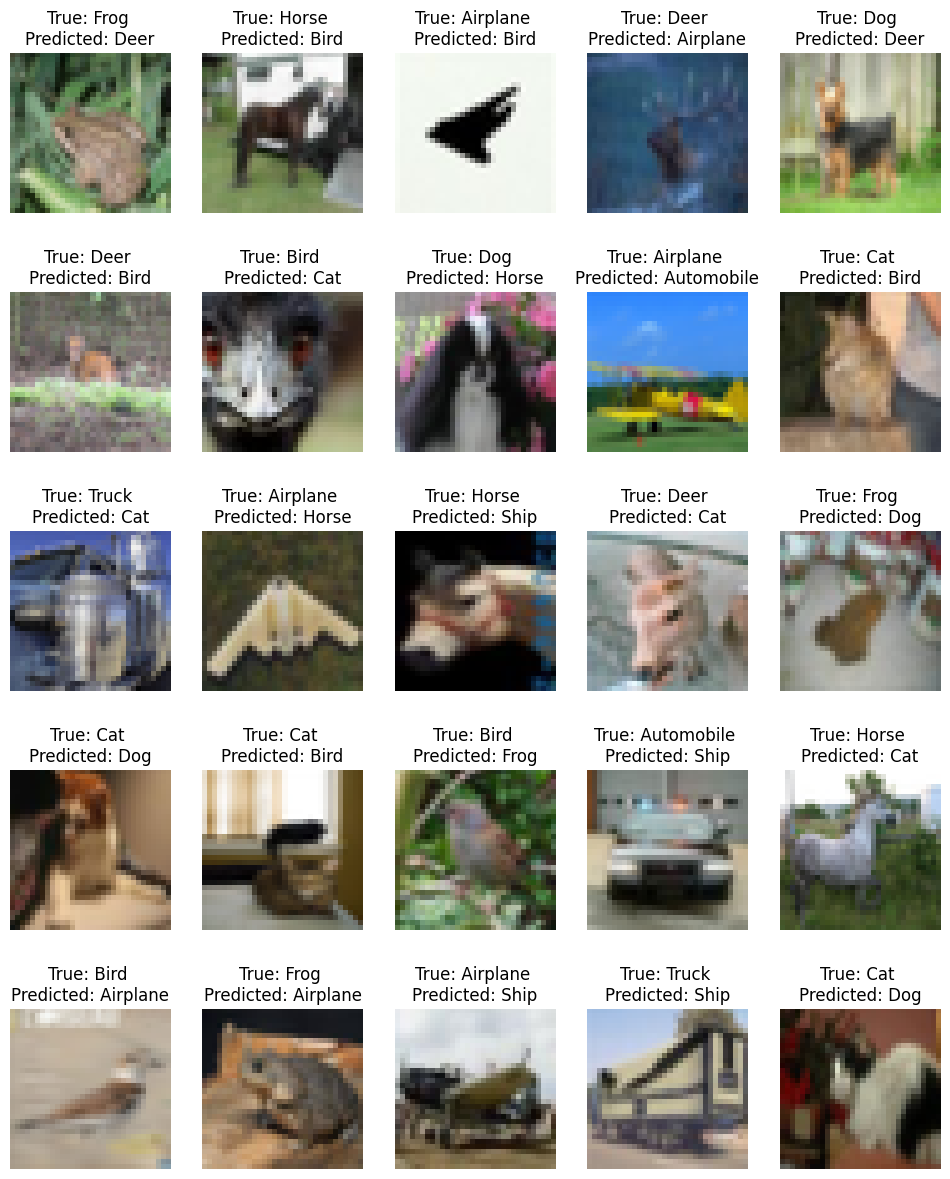

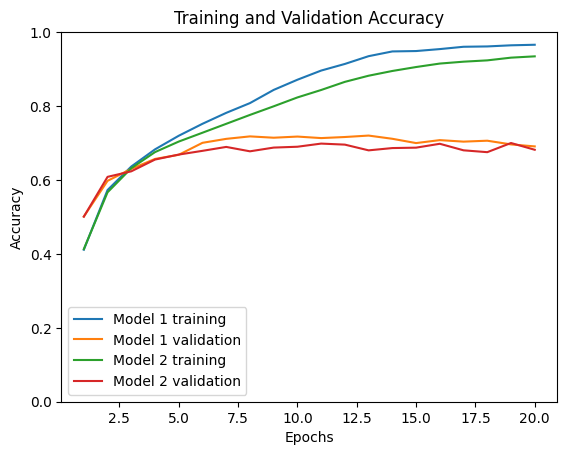

In [11]:
train_accuracy_1, val_accuracy_1 = main(AlexNet((3,3), (2,2)))
train_accuracy_2, val_accuracy_2 = main(AlexNet((3,3), (2,2)), batch=32)

my_plot_accuracy(train_accuracy_1, val_accuracy_1, train_accuracy_2, val_accuracy_2)

SHAPES:  (100000, 32, 32, 3) (100000, 10) (10000, 32, 32, 3) (10000, 10)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 15, 15, 32)        9248      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 7, 7, 32)          9248      
                                               

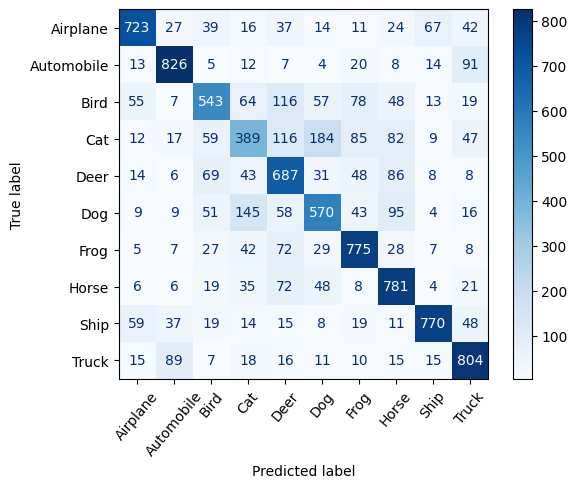

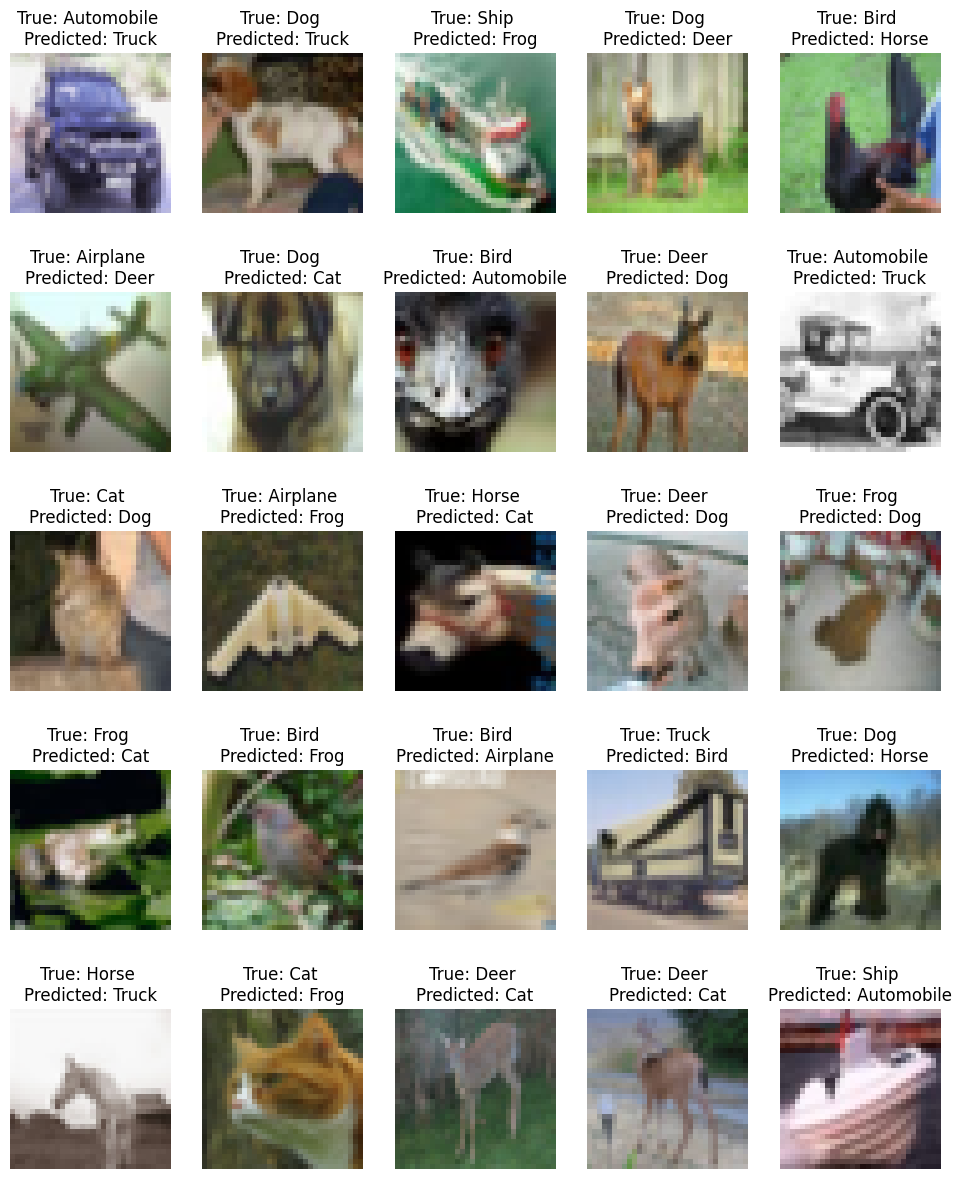

SHAPES:  (50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 15, 15, 32)        9248      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (None, 7, 7, 32)          9248      
                                                 

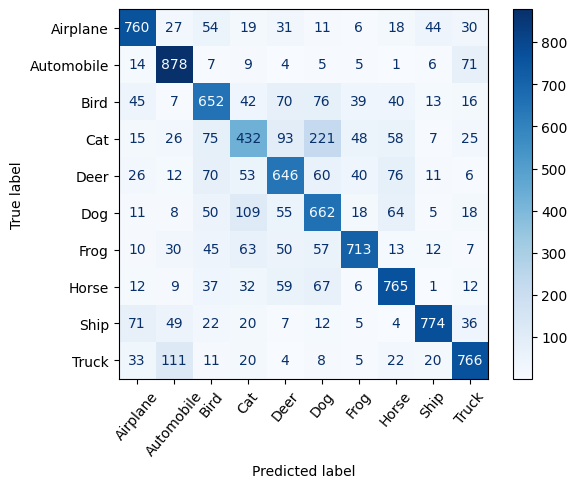

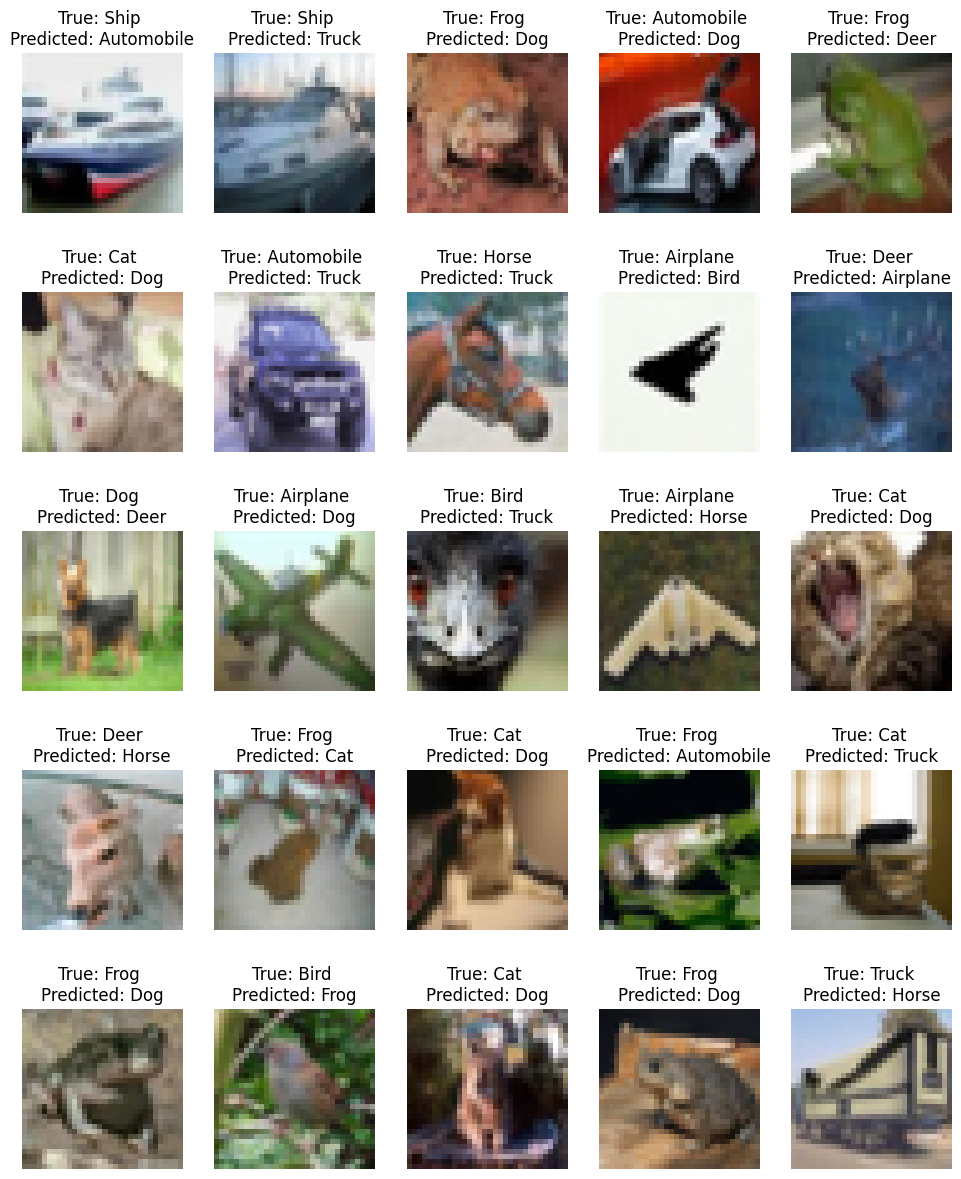

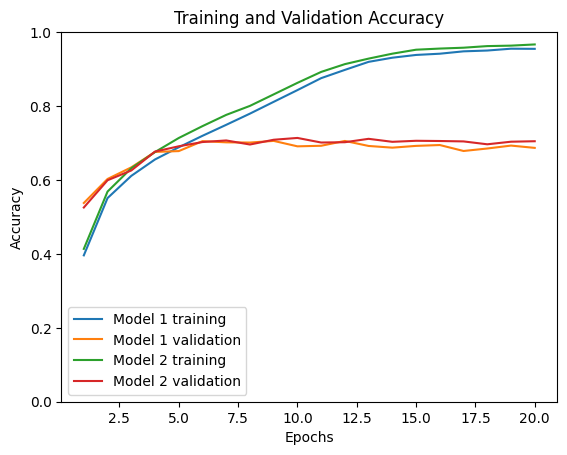

In [39]:
train_accuracy_1, val_accuracy_1 = main(AlexNet((3,3), (2,2)), augmentation=True)
train_accuracy_2, val_accuracy_2 = main(AlexNet((3,3), (2,2)), augmentation=False)

my_plot_accuracy(train_accuracy_1, val_accuracy_1, train_accuracy_2, val_accuracy_2)

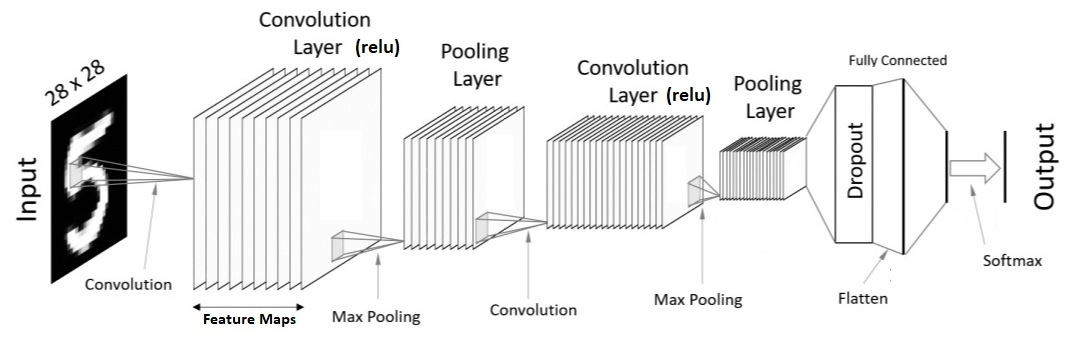

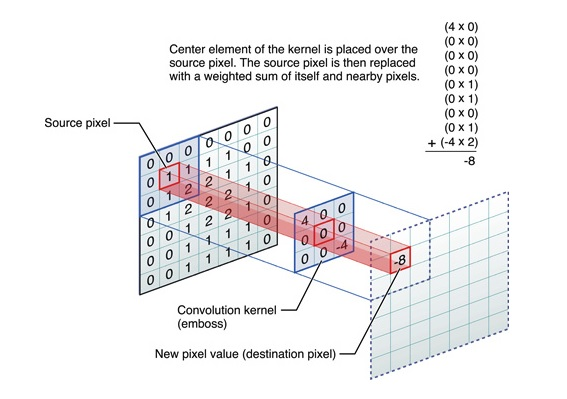

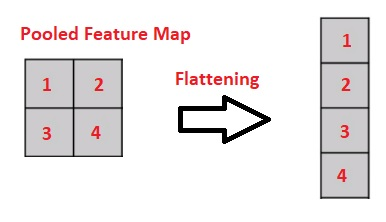